# E2E-Part-5: Deploying Trained model on Kserve


This notebook walks you each step to deploy a custom object detection model on KServe. 

We will show you how to:

* Install Kserve Natively using Kind and Knative
* Create a Persistent Volume Claim for local model deployment
* Preparing custom model for Kserve inference
* Deploying model using a KServe InferenceService
* Complete a sample request and plot predictions

Note: This notebook was tested on a Linux-based machine with Nvidia T4 GPUs. We also assume Docker is installed in your Linux system/environment

Let's get started!

# Pre-reqs: Setting up Python and Jupyter Lab environment:
Run the below commands to set up a python virtual environment, and install all the python packages needed for this tutorial
```
sudo apt-get update && sudo apt-get  install python3.8-venv
python3 -m venv kserve_env
source kserve_env/bin/activate
pip install kserve jupyterlab torch-model-archiver
pip install torch==1.11.0 torchvision==0.12.0 matplotlib
jupyter lab --ip=0.0.0.0 \
  --port=8008 \
  --NotebookApp.token='' \
  --NotebookApp.password=''
```

# Install Kserve Natively using Kind and Knative

## Install Kind
Open a Terminal and run the following bash commands to install a kubernetes cluster using Kind:
* `curl -Lo ./kind https://kind.sigs.k8s.io/dl/v0.18.0/kind-linux-amd64`
* `chmod +x ./kind`
* `sudo mv ./kind /usr/local/bin/kind`

After running these commands, create a cluster by running the command: `kind create cluster`

## Install Kubectl
Run the following bash commmands in a terminal to to install the kubectl runtime:
* `curl -LO "https://dl.k8s.io/release/$(curl -L -s https://dl.k8s.io/release/stable.txt)/bin/linux/amd64/kubectl"`
* `curl -LO "https://dl.k8s.io/$(curl -L -s https://dl.k8s.io/release/stable.txt)/bin/linux/amd64/kubectl.sha256"`
* `sudo install -o root -g root -m 0755 kubectl /usr/local/bin/kubectl`

## Install Kserve

Run this bash script to install KServe onto our default Kubernetes Cluster, note this will install the following artifacts:
* ISTIO_VERSION=1.15.2, KNATIVE_VERSION=knative-v1.9.0, KSERVE_VERSION=v0.9.0-rc0, CERT_MANAGER_VERSION=v1.3.0

* `bash e2e_blogposts/ngc_blog/kserve_utils/bash_scripts/kserve_install.sh`

## Patch Domain for local connection to KServe cluster/environment
Run this command to patch your cluster when you want to connect to your cluster on the same machine:

`kubectl patch cm config-domain --patch '{"data":{"example.com":""}}' -n knative-serving`

## Run Port Forwarding to access KServe cluster
* `INGRESS_GATEWAY_SERVICE=$(kubectl get svc --namespace istio-system --selector="app=istio-ingressgateway" --output jsonpath='{.items[0].metadata.name}')`
* `kubectl port-forward --namespace istio-system svc/${INGRESS_GATEWAY_SERVICE} 8080:80`

Make sure to open a new terminal to continue the configuration. 

# Create a Persistent Volume Claim for local model deployment

We will be creating a Persistent Volume Claim to host and access our Pytorch based Object Detection model locally. A persistent volume claim requires three k8s artifacts:
* A Persistent Volume
* A Persistent Volume Claim
* A K8S pod that connects the PVC to be accessed by other K8S resources

## Creating a Persistent Volume and Persistent Volume Claim
Below is the yaml definition that defines the Persistent Volume (PV) and a Persistent Volume Claim (PVC). We already created a file that defines this PV in `k8s_files/pv-and-pvc.yaml`

```yaml
apiVersion: v1
kind: PersistentVolume
metadata:
  name: task-pv-volume
  labels:
    type: local
spec:
  storageClassName: manual
  capacity:
    storage: 2Gi
  accessModes:
    - ReadWriteOnce
  hostPath:
    path: "/home/ubuntu/mnt/data"
---
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: task-pv-claim
spec:
  storageClassName: manual
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 1Gi
```

To create the PV and PVC, run the command: `kubectl apply -f k8s_files/pv-and-pvc.yaml`

## Create K8s Pod to access PVC
Below is the yaml definition that defines the K8s Pod that mounts the Persistent Volume Claim (PVC). We already created a file that defines this PV in `k8s_files/model-store-pod.yaml`

```yaml
apiVersion: v1
kind: Pod
metadata:
  name: model-store-pod
spec:
  volumes:
    - name: model-store
      persistentVolumeClaim:
        claimName: task-pv-claim
  containers:
    - name: model-store
      image: ubuntu
      command: [ "sleep" ]
      args: [ "infinity" ]
      volumeMounts:
        - mountPath: "/pv"
          name: model-store
      resources:
        limits:
          memory: "1Gi"
          cpu: "1"
```

To create the Pod, run the command: `kubectl apply -f k8s_files/model-store-pod.yaml`

# Preparing custom model for Kserve inference

Here we will complete some preparation steps to deploy a trained custom FasterRCNN Object Detection model using KServe. A pre-requisite is to download a checkpoint from a determined experiement. You can read this [tutorial](https://docs.determined.ai/latest/training/model-management/checkpoints.html#downloading-checkpoints-using-the-cli) on how to download a checkpoint using the Determined CLI. For this tutorial, you can download an already prepared checkpoint using the following bash command:

* `wget -O kserve_utils/torchserve_utils/trained_model.pth https://determined-ai-xview-coco-dataset.s3.us-west-2.amazonaws.com/trained_model.pth`

## Stripping the Checkpoint of the Optimizer State Dict

Checkpoints created from a Determined Experiment will save both the model parameters and the optimizer parameters. We will need to strip the checkpoint of all parameters except the model parameters for inference. Run the bash command to generate `train_model_stripped.pth`:

Run the below command in a terminal:

```bash
python kserve_utils/torchserve_utils/strip_checkpoint.py --ckpt-path kserve_utils/torchserve_utils/trained_model.pth \
  --new-ckpt-name kserve_utils/torchserve_utils/trained_model_stripped.pth
```

## Run TorchServe Export to create .mar file

Run the below command to export the Pytorch Checkpoint into a .mar file that is required for torchserve inference. Our Kserve InferenceService will automatically deploy a Pod with a docker image that support TorchServe inferencing.

```bash
torch-model-archiver --model-name xview-fasterrcnn \
  --version 1.0 \
  --model-file kserve_utils/torchserve_utils/model-xview.py \
  --serialized-file kserve_utils/torchserve_utils/trained_model_stripped.pth \
  --handler kserve_utils/torchserve_utils/fasterrcnn_handler.py \
  --extra-files kserve_utils/torchserve_utils/index_to_name.json
```

After command finishes, run command to move file to our prepared `model-store/` directory:
* `cp xview-fasterrcnn.mar kserve_utils/torchserve_utils/model-store -v`

## Copy `config/` and `model-store/` folders to the K8S PVC Pod

This is the directory structure needed to prepare our custom Pytorch Model for KServe inferencing:
```
├── config
│   └── config.properties
├── model-store
│   ├── properties.json
│   └── xview-fasterrcnn.mar
```

### What the config.properties file looks like

```
inference_address=http://0.0.0.0:8085
management_address=http://0.0.0.0:8085
metrics_address=http://0.0.0.0:8082
grpc_inference_port=7070
grpc_management_port=7071
enable_metrics_api=true
metrics_format=prometheus
number_of_netty_threads=4
job_queue_size=10
enable_envvars_config=true
install_py_dep_per_model=true
model_store=/mnt/models/model-store
model_snapshot={"name": "startup.cfg","modelCount": 1,"models": {"xview-fasterrcnn": {"1.0": {"defaultVersion": true,"marName": "xview-fasterrcnn.mar","serialized-file":"trained_model_stripped.pth","extra-files":"index_to_name.json","handler":"fasterrcnn_handler.py","minWorkers": 1,"maxWorkers": 5,"batchSize": 1,"maxBatchDelay": 100,"responseTimeout": 120}}}}
```

### What the properties.json looks like

```
[
    {
    "model-name": "xview-fasterrcnn",
    "version": "1.0",
    "model-file": "",
    "serialized-file": "trained_model_stripped.pth",
    "extra-files": "index_to_name.json",
    "handler": "fasterrcnn_handler.py",
    "min-workers" : 1,
    "max-workers": 3,
    "batch-size": 1,
    "max-batch-delay": 100,
    "response-timeout": 120,
    "requirements": ""
  }
]
```

Note that we have a `config/` folder that includes a config.properties. This defines A. We also have a `model-store/` directory that contains are exported models and a `properties.json` file. We need this file for B

Now we will run several kubectl commands to copy over these folders into our Pod and into the PVC defined directory
* `kubectl cp kserve_utils/torchserve_utils/config/ model-store-pod:/pv/config/`
* `kubectl cp kserve_utils/torchserve_utils/model-store/ model-store-pod:/pv/model-store/`

Run these commands to verify the contents have been copied over to the pod.
* `kubectl exec --tty model-store-pod -- ls /pv/config`
* `kubectl exec --tty model-store-pod -- ls /pv/model-store`

# Deploying model using a KServe InferenceService

## Create Inference Service

Below is the yaml definition that defines the KServe InferenceService that deploys models stored in the PVC. We already created a file that defines this PV in `k8s_files/torch-kserve-pvc.yaml`

```yaml
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "torchserve"
spec:
  predictor:
    pytorch:
      storageUri: pvc://task-pv-claim/
```

To create the Pod, run the command: `kubectl apply -f kserve_utils/k8s_files/torch-kserve-pvc.yaml`

#### - After running the previous command `kubectl get inferenceservice`, you should see that the inferenceservice is not loaded yet
<img src="img_content/inf_service_not_loaded.png" width="800" />

#### - Keep running the command every minute until you see the InferenceService loaded (view screenshot below of example)
<img src="img_content/inf_service_loaded.png" width="800" />

#### - Next, run command `kubectl get pods` to get underlying pod that is running inference service. Copy the pod name (example seen in screenshot)
<img src="img_content/get_pod_name.png" width="800" />

#### - Finally run command: `kubectl logs -f <POD_NAME>` to see the logs and if the model was successfully loaded. 

<img src="img_content/check_logs.png" width="800" />


# Complete a sample request and plot predictions

In [1]:
import json
import requests
import base64
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt 

In [2]:
filename='kserve_utils/torchserve_utils/example_img.jpg'
im = Image.open(filename)


Here is the test image we will send to the Deployed Model

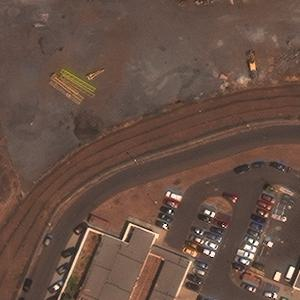

In [3]:
im

Here we will encode the image into into base64 binary format 

In [4]:
image = open(filename, 'rb')  # open binary file in read mode
image_read = image.read()
image_64_encode = base64.b64encode(image_read)
bytes_array = image_64_encode.decode('utf-8')
request = {
  "instances": [
    {
      "data": bytes_array
    }
  ]
}
result_file = "{filename}.{ext}".format(filename=str(filename).split(".")[0], ext="json")
print("Result File: ",result_file)
with open(result_file, 'w') as outfile:
    json.dump(request, outfile, indent=4, sort_keys=True)


Result File:  kserve_utils/torchserve_utils/example_img.json


Lets submit the image to our deployed endpoint and visualize the predictions!

In [5]:
headers = {
    "Host": "torchserve.default.example.com"
}

data = open(result_file)
response = requests.post('http://localhost:8080/v1/models/xview-fasterrcnn:predict', headers=headers, data=data)

resp = json.loads(response.content)

print("Number of Predictions: ", len(resp['predictions'][0]))

Number of Predictions:  95


In [6]:
draw = ImageDraw.Draw(im)

In [7]:
for pred in resp['predictions'][0]:
    assert len(list(pred.keys())) == 2
    cl_name = list(pred.keys())[0]
    bboxes = pred[cl_name]
    # print(cl_names)
    # print(bboxes)
    # print("score: ",pred['score'])
    if pred['score'] > 0.4:
        # bboxes = [int(i) for i in bboxes]
        # print(bboxes[0],type(bboxes[0]))
        draw.rectangle([bboxes[0],bboxes[1],bboxes[2],bboxes[3]],outline=(255,0,0),fill=None,width=1)
        draw.text([bboxes[0],bboxes[1]-10],"{} :{:.2f}".format(cl_name,pred['score']),fill=(250,0,0))

Here we will see the model predictions overlaid on the input image

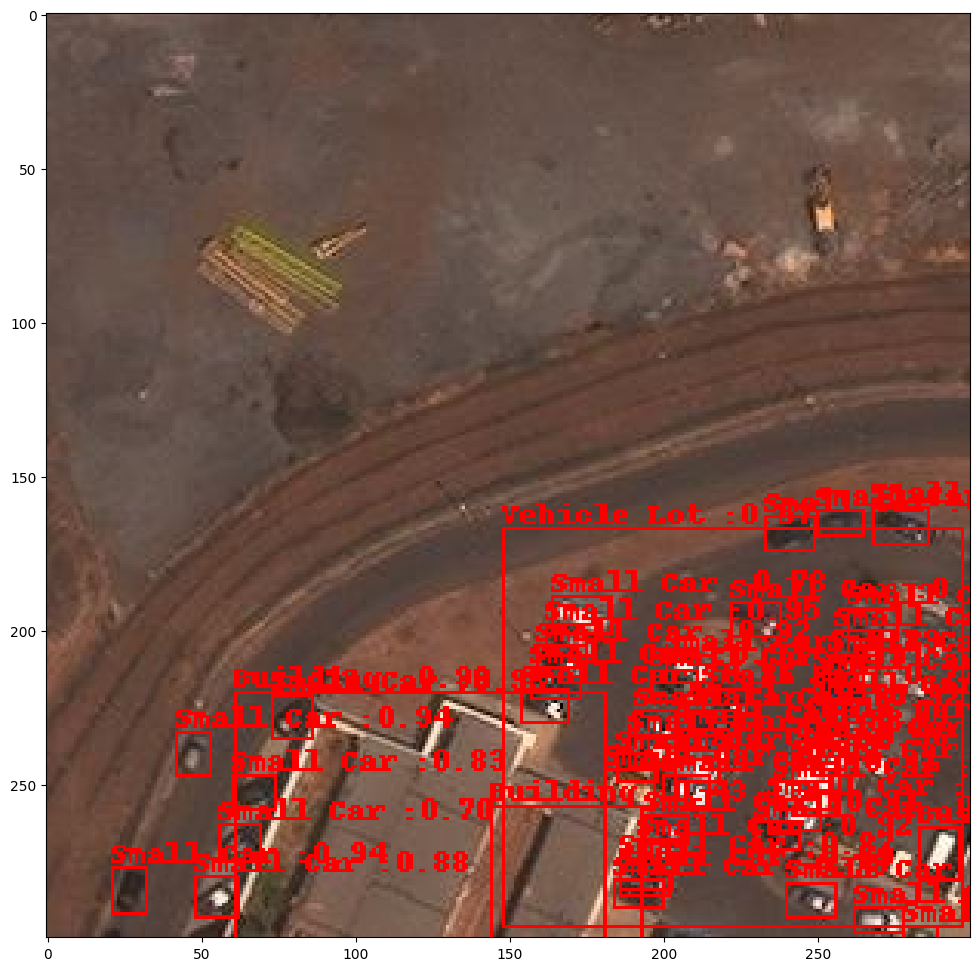

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(im)